In [36]:
from transformers import pipeline
from PIL import Image

import copy
from PIL import Image
import numpy as np

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")


In [2]:
def image_to_numpy(image):
    # https://stackoverflow.com/questions/10965417
    im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
    return im_arr.reshape((image.size[1], image.size[0], 3))


In [30]:
class Model:

    _detector = None

    def __init__(self, prompts, threshold):
        self.prompts = prompts
        self.threshold = threshold

    @property
    def detector(self):
        if self._detector:
            return self._detector
        
        checkpoint = "google/owlv2-base-patch16-ensemble"
        self._detector = pipeline(model=checkpoint, task="zero-shot-object-detection")
        return self.detector        

    def _apply_detector(self, image: Image):
        return self.detector(
            image,
            candidate_labels=self.prompts,
            threshold=self.threshold,
        )

    def _filter_area(self, predictions, max_area=500):
        def get_area(p):
            width = p["box"]["xmax"] - p["box"]["xmin"]
            height = p["box"]["ymax"] - p["box"]["ymin"]
            return width * height

        return [
            p
            for p in predictions
            if get_area(p) < max_area
        ]
    
    def _filter_proposals(self, proposals):
        return self._filter_area(proposals)

    def _return_middle(self, proposals):
        def get_middle(p):
            width = p["box"]["xmax"] - p["box"]["xmin"]
            height = p["box"]["ymax"] - p["box"]["ymin"]
            return width + p["box"]["xmin"], height + p["box"]["ymin"]
        
        return [
            get_middle(p)
            for p in proposals
        ]

    def predict(self, image):
        image = Image.fromarray(image)
        proposed_boxes = self._apply_detector(image)
        filtered_boxes = self._filter_proposals(proposed_boxes)
        return self._return_middle(filtered_boxes)

    def get_boxes(self, image):
        image = Image.fromarray(image)
        proposed_boxes = self._apply_detector(image)
        return proposed_boxes


In [53]:
image = Image.open("Bild1.png")

clock_model = Model(["clock"], .5)
orange_box_model = Model(["orange box"], .05)
blue_screen_model = Model(["blue box"], .05)


results = [
    e
    for m in (
        Model(["clock"], .5),
        Model(["orange box"], .05),
        Model(["railroad track"], .4),
        Model(["street lamp"], .2),
        Model(["railroad signal"], .2),
    )
    for e in m.get_boxes(np.array(image))
]


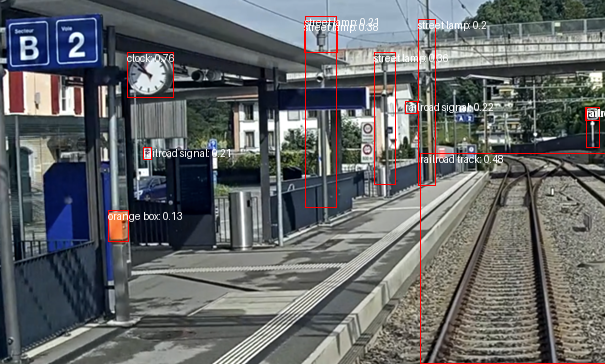

In [54]:
from PIL import ImageDraw

image_to_draw = Image.open("Bild1.png")
draw = ImageDraw.Draw(image_to_draw)

for prediction in results:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")

image_to_draw